# Learning Algorithm and Hyperparameters
## MADDPG
I chose to implement Multi-Agent Deep Deterministic Policy Gradients (MADDPG) to solve the environment.  Standard DDPG is an offline, policy gradient-based algorithm that trains two categories of networks: actors and critics.  The actor accepts the environment's state as an input and outputs the action that maximizes expected long term rewards.  The critic accepts the environment's state plus a chosen action as an input and outputs an estimate of that state, action pair's Q-value.  Both actor and critic are trained using a replay buffer; the actor makes decisions on which action to take, and the original state, new state, action, and reward are recorded in the replay buffer.  To train, these experiences are randomly sampled and combined into a batch to use for a forward pass through the networks and ultimately a gradient calculation and update step.  DDPG also makes use of separate target networks for both actor and critic which are soft-updated from the "online" networks rather than directly trained.  This effectively decreases the learning rate for the target networks, improving stability and preventing performance-reducing feedback loops.

The multi-agent version of DDPG is very similar to standard DDPG.  The significant difference is that a single critic accepts a combination of all agents' states and actions, rather than each agent having its own dedicated critic.  This use of a critic which is aware of all agents' observations and actions addresses one of the major difficulties encountered in multi-agent RL: dealing with non-stationary environments.  The environment itself may not be stationary, but the environment is stationary given the actions of an agent.  Thus, the critic, whose output is dependent on all of those states and actions, is able to provide stability to the whole system.  The individual actors can be modelled using one network, or can be separate networks; I found that I achieved better performance using a single network with one set of weights for both the left and right player, so my implementation only contains one actor network (plus the target actor).

Because the critic is essentially a Q-learner, its loss function is fairly straightforward, and it can be trained just like a traditional DQN.  The target networks are used when calculating both the optimal action in $s_{t+1}$ as well as the value of that state, action pair.  The loss is simply the mean squared error between the Q-value of the current state and the reward plus discounted Q-value from these target networks in the new state.

$loss_{critic} = mean((r + \gamma Q_{target}(s_{t+1}, actor_{target}(s_{t+1})) - Q_{local}(s_t, a_t))^2)$

For the policy gradient, our goal is just to return the action that maximizes expected return.  Since the Q-value *is* the expected return, we can just take the gradient of the Q-value.  Therefore, we can write our loss as:

$loss_{actor} = mean(-Q_{local}(s_t, actor_{local}(s_t)))$


## Neural Network Architecture
Both the actor and critic networks contain one input, two hidden, and one output layer.  All layers are fully connected.  The hidden layers all use `relu` activation functions.

The critic network takes an input of the concatenated tensor of both agents' local state observations, plus a concatenated tensor of both agents' actions.  It contains a single output, with a linear activation function, representing the estimated value of the  state, action combination.

The actor network takes an agent's local state observation as input and outputs a tensor representing the optimal actions given that state.  The output uses a tanh activation function, which compresses the outputs to the range \[-1, 1\], matching with the environment's action space.  This actor network can accept and make predictions for either agent's actions without being told explicitly which agent's state obvservation it receives as input.  

In order to more closely mirror the state characteristics between agents, I implemented a function `utils.mirror_states_` which will modify one agent's state to be more numerically similar to the other agent's, improving learning.  Specifically, I noticed that the fifth, thirteenth, and twenty-first values of the state space for the left agent were the same as those of the right agent, but multiplied by -1.  To fix this, the function simply multiplies those values in the right agent's observation by -1.  I found that making this change improved training by decreasing the differences between the agents' state spaces.

## Exploration: Ornstein–Uhlenbeck Noise

Since DDPG's actions are deterministic, exploration needs to be forced by adding random noise to the agent's actions.  To do this, I used a modified version of the MADDPG's Ornstein–Uhlenbeck process implementation.  The Ornstein–Uhlenbeck allows for the creation of temporally correlated noise, which is added to the agent's actions.

During training, I noticed that noise was critical to the early exploration phase, but too much noise caused the agent to stop learning later on in the process as they approached a rolling average score of 0.1.  To address this, I implemented an approach that I call "Adaptive Noise Scaling."  This approach allows for a large amount of noise while the agent is performing poorly, and decreases the noise as performance improved.  It is controlled by two hyperparameters: `NOISE_LIMIT` and `ADAPTIVE_NOISE_TARGET_SCORE`, $score_{target}$.  The noise limit is the baseline value by which the noise generated by the OU process is multiplied assuming the agent is performing poorly.  The target is the value at which the noise should be reduced to zero.  As the agent improves, the rolling 100-episode mean score is recorded and compared to the target score once every fifty episodes; as the difference between the two decreases, the scale of the noise is linearly decreased to zero.

$scale = min(\frac{max(score_{target} - score_{current}, 0)}{score_{target}}*limit, limit)$

For my first attempt at using this noise scaling, I set the target score to 0.5, to mirror the definition of "solving" the environment.  However, I found that a target score of 0.25 performed better.  I suspect that this is due to the nature of the environment; any mistake is heavily penalized not only by the negative reward associated with that mistake, but also by the termination of the episode and the loss of the ability to earn more future rewards.  Even if a policy is perfect, noise can make the agent play poorly if it is too large, preventing further learning.

## Hyperparameters
The hyperparameters used for training are shown in the tables below:


### Training Loop Parameters
| Parameter          | Parameter Value |
|--------------------|-----------------|
| Number of Episodes | 5000            |
| Tau                | 1e-3            |
| Gamma              | 0.99            |
| Update Every       | 1 step          |
| Memory Buffer Size | 1e6             |
| Batch Size         | 256             |

### OU Noise Parameters
| Parameter                   | Parameter Value |
|-----------------------------|-----------------|
| Adaptive Noise Target Score | 0.25            |
| Noise Limit                 | 1.0             |
| Sigma                       | 0.5             |

### Network Parameters
| Parameter                | Parameter Value |
|--------------------------|-----------------|
| Actor Learning Rate      | 1e-3            |
| Critic Learning Rate     | 3e-3            |
| Actor Hidden Layer Size  | 128             |
| Critic Hidden Layer Size | 128             |
| Batchnorm Inputs?        | False           |

Overall, I found that MADDPG was highly sensitive to hyperparameters.  In particular, increasing my replay buffer size and batch size, as well as decreasing my network sizes while increasing the learning rates all helped with learning.  The OU noise parameters were also very significant; increasing sigma significantly up to 0.5 was crucial in good exploration, as well as the implementation and tuning of the adaptive noise scaling.

# Training Process



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
training_scores = pd.read_csv("scores/training_scores.csv")

In [9]:
max_scores_per_episode = training_scores.max(axis=1)
rolling_avg_scores = max_scores_per_episode.rolling(100).mean()

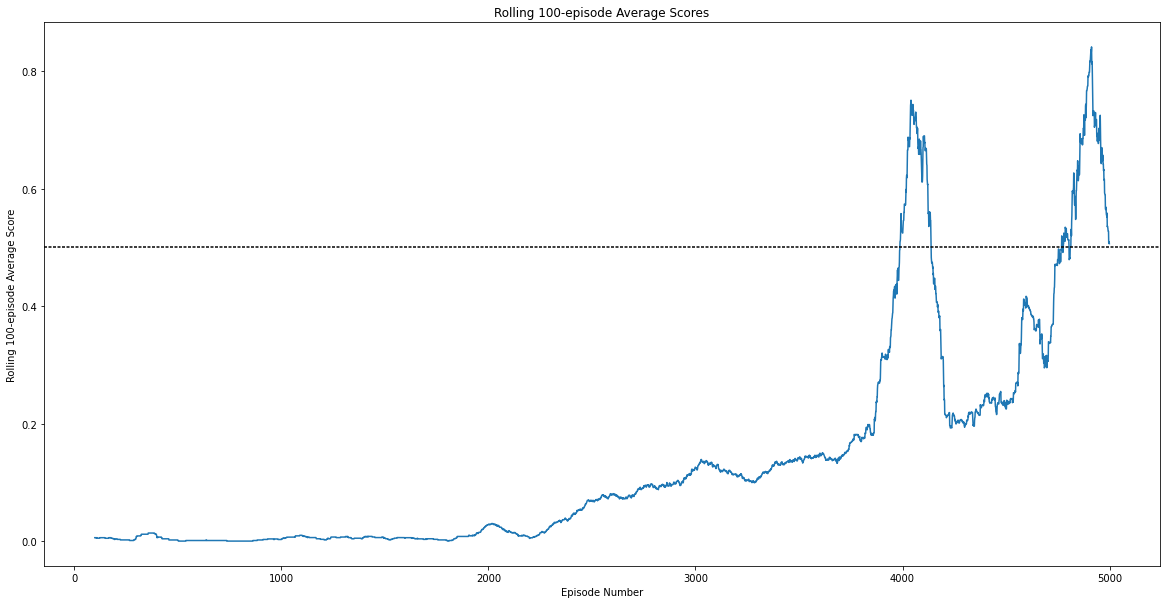

In [10]:
rolling_avg_scores.plot(figsize=(20, 10))
plt.title("Rolling 100-episode Average Scores")
plt.xlabel("Episode Number")
plt.ylabel("Rolling 100-episode Average Score")
plt.axhline(y=0.5, color="black", dashes=(2,1))
plt.show()

In [12]:
print("The agents first achieved a 100-episode rolling average score of >.5 on episode",(rolling_avg_scores > .5).idxmax())

The agents first achieved a 100-episode rolling average score of >.5 on episode 3988


As seen above, the learning process was quite slow and unstable.  I believe this instability reflects the inherent complexity of a multi-agent system.  While the environment was solved on episode 3988, the performance quickly dropped significantly, then recovered again.

# Ideas For Future Work

As seen in my results, my agent certainly has room for improvement in both training speed and stability.  One area that I think could potentially improve performance is enhancing the adaptive noise weighting.  I think keeping a little bit of noise even while the agents are performing well could avoid the rapid spikes and drops seen here.  One idea of how to do this would be scaling down the noise gemoetrically, rather than linearly.  [Lowe et. al \(2017\)](https://arxiv.org/pdf/1706.02275v4.pdf) also mention direct modeling of other agents' policies within each agent's network.  Adding this could potentially decrease some of the instability as well.

There is also more room for hyperparameter tuning.  While I modified sigma and scale, I did not modify any other parts of the OU noise process, and changing these could be fruitful given the significance of noise on the agents' learning process.  In addition, modifying tau or decreasing the frequency of updates could allow for more control and stability during training; I did not experiment with either of these while I trained the agents.